# EDA - Airbnb Demand models


In [1]:
#import necessary packages
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql.functions import *
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#Importing statsmodels
import statsmodels.api as sm
#Support for formulas
import statsmodels.formula.api as smf
#Use glm() directly
from statsmodels.formula.api import glm
import lifelines
from lifelines import KaplanMeierFitter

# Data loading and cleanning

In [2]:
#read files (chicago)
df_listing_chicago = pd.read_csv('listings Chicago.csv')
df_listing_chicago['listing_id'] = df_listing_chicago['id']
df_review_chicago = pd.read_csv('reviews Chicago.csv')
df_review_chicago = df_review_chicago[['listing_id', 'comments']]

#read files (new york)
df_listing_NY = pd.read_csv('listings New York.csv')
df_listing_NY['listing_id'] = df_listing_chicago['id']
df_review_NY = pd.read_csv('reviews New York.csv')
df_review_NY = df_review_NY[['listing_id', 'comments']]

#read files (LA)
df_listing_LA = pd.read_csv('listings LA.csv')
df_listing_LA['listing_id'] = df_listing_chicago['id']
df_review_LA = pd.read_csv('reviews LA.csv')
df_review_LA = df_review_LA[['listing_id', 'comments']]

/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_8917/2399590587.py:8: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listing_NY = pd.read_csv('listings New York.csv')


In [3]:
#replacing nonstring values in comments (NaN is considered float)
df_review_chicago.comments = np.where(df_review_chicago.comments.isnull(),'none',df_review_chicago.comments)
df_review_NY.comments = np.where(df_review_NY.comments.isnull(),'none',df_review_NY.comments)
df_review_LA.comments = np.where(df_review_LA.comments.isnull(),'none',df_review_LA.comments)

#concatenate all comments for the same listing
df_review_chicago = df_review_chicago.groupby(['listing_id'], as_index = False).agg({'comments': ' '.join})
df_review_NY = df_review_NY.groupby(['listing_id'], as_index = False).agg({'comments': ' '.join})
df_review_LA = df_review_LA.groupby(['listing_id'], as_index = False).agg({'comments': ' '.join})

#merge two files and add city name
df_chicago = pd.merge(df_listing_chicago, df_review_chicago, on = 'listing_id', how = 'left')
df_NY = pd.merge(df_listing_NY, df_review_NY, on = 'listing_id', how = 'left')
df_LA = pd.merge(df_listing_LA, df_review_LA, on = 'listing_id', how = 'left')

df_chicago['city'] = 'Chicago'
df_NY['city'] = 'New York'
df_LA['city'] = 'Los angeles'

In [4]:
#union data of three cities 
df = pd.concat([df_chicago, df_NY, df_LA])

#keep needed fields only
df = df[['city','listing_id', 'name', 'description', 'neighborhood_overview', 
          'host_listings_count', 'host_identity_verified', 'host_total_listings_count', 'latitude', 'longitude',
         'property_type', 'room_type', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 
          'minimum_nights', 'maximum_nights', 'has_availability', 'number_of_reviews', 'first_review', 'last_review', 
          'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
          'review_scores_communication', 'review_scores_location', 
          'review_scores_value', 'license', 'instant_bookable', 'comments']]

#df["Dead"] = df["status"].apply(lambda x: 1 if x == 2 else 0 if x ==1 else null)
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df["price"] = pd.to_numeric(df["price"])

/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_8917/2530105388.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '').str.replace(',', '')


In [5]:
df.head(2)

,city,listing_id,name,description,neighborhood_overview,host_listings_count,host_identity_verified,host_total_listings_count,latitude,longitude,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,comments
0,Chicago,2384.0,Hyde Park - Walk to UChicago,You are invited to be the sole Airbnb guest in...,The apartment is less than one block from beau...,1.0,t,1.0,41.78790,-87.58780,...,4.99,4.98,4.99,4.99,4.99,4.96,4.94,R17000015609,t,it's a wonderful trip experience. I didn't exc...
1,Chicago,7126.0,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",2.0,t,2.0,41.90166,-87.68021,...,4.68,4.84,4.56,4.90,4.87,4.88,4.74,R21000075737,f,We really enjoyed our stay at Sarah's place! ...


# Explorative Data Analysis

In [6]:
#create spark session to do a more complex 
from pyspark.sql import SparkSession
from pyspark.sql import Row
appName= "hive_pyspark"
master= "local"

spark = SparkSession.builder.master(master).appName(appName).enableHiveSupport().getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/20 11:51:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark_df = df[['city', 'listing_id', 'host_total_listings_count', 
                'property_type', 'room_type', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews',
               'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value'
              ]]

#replace the Nans for a string so that converting pandas data frame to Spark Data Frame for doing more complex process
spark_df["city"] = spark_df["city"].fillna("Nan values")
spark_df["property_type"] = spark_df["property_type"].fillna("Nan values")
spark_df["room_type"] = spark_df["room_type"].fillna("Nan values")

/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_8917/179489154.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spark_df["city"] = spark_df["city"].fillna("Nan values")
/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_8917/179489154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spark_df["property_type"] = spark_df["property_type"].fillna("Nan values")
/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_8917/179489154.py:10: SettingWithCopyWarning: 
A value is trying to b

In [8]:
# Create a Spark DataFrame from Pandas
spark_df = spark.createDataFrame(spark_df)

#registrate table for spark sql use
spark_df.registerTempTable("spark_df")
spark_df.printSchema()

/Users/lianliu/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


root
 |-- city: string (nullable = true)
 |-- listing_id: double (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- price: double (nullable = true)
 |-- number_of_reviews: long (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true)
 |-- review_scores_location: double (nullable = true)
 |-- review_scores_value: double (nullable = true)



In [16]:
# check how many listings by city
listing_by_city = spark.sql("select city, count(listing_id) as listing_counts \
          from spark_df \
          group by city")
listing_by_city.registerTempTable("listing_by_city")
listing_by_city.show()

22/11/20 12:00:18 WARN TaskSetManager: Stage 12 contains a task of very large size (11748 KiB). The maximum recommended task size is 1000 KiB.
+-----------+--------------+
|       city|listing_counts|
+-----------+--------------+
|    Chicago|          7414|
|Los angeles|         45815|
|   New York|         39881|
+-----------+--------------+



In [74]:
# check how many listings by city and average price of property type
listing_by_propertytype = spark.sql("select city, property_type, \
            count(distinct listing_id) as listing_counts, \
            avg(price) as average_price\
          from spark_df \
          group by city, property_type \
          order by listing_counts desc")

listing_by_propertytype.registerTempTable("listing_by_propertytype")

### Average prices by property type in each city

In [76]:
chicago_property = spark.sql(
            "select city, property_type, listing_counts, average_price \
                from listing_by_propertytype a \
                where city = 'Chicago' \
                order by listing_counts desc limit 5")

chicago_property = chicago_property.toPandas()
chicago_property.head()

22/11/20 13:44:36 WARN TaskSetManager: Stage 115 contains a task of very large size (11748 KiB). The maximum recommended task size is 1000 KiB.


,city,property_type,listing_counts,average_price
0,Chicago,Entire rental unit,3627,215.247036
1,Chicago,Entire condo,851,275.717979
2,Chicago,Private room in rental unit,571,79.124343
3,Chicago,Private room in home,521,74.850288
4,Chicago,Entire home,519,420.473988


In [77]:
NY_property = spark.sql("select city, property_type, listing_counts, average_price \
                             from listing_by_propertytype a \
                             where city = 'New York' \
                             order by listing_counts desc limit 5")

NY_property = NY_property.toPandas()
NY_property.head()

22/11/20 13:44:36 WARN TaskSetManager: Stage 121 contains a task of very large size (11748 KiB). The maximum recommended task size is 1000 KiB.


,city,property_type,listing_counts,average_price
0,New York,Entire rental unit,3540,225.887679
1,New York,Private room in rental unit,2396,97.172371
2,New York,Private room in home,278,84.536585
3,New York,Entire home,237,288.152439
4,New York,Entire loft,162,383.205094


In [78]:
LA_property = spark.sql("select city, property_type, listing_counts, average_price \
                             from listing_by_propertytype a \
                             where city = 'Los angeles' \
                             order by listing_counts desc limit 5")

LA_property = LA_property.toPandas()
LA_property.head()

22/11/20 13:44:38 WARN TaskSetManager: Stage 127 contains a task of very large size (11748 KiB). The maximum recommended task size is 1000 KiB.


,city,property_type,listing_counts,average_price
0,Los angeles,Entire rental unit,1727,181.636033
1,Los angeles,Entire home,1465,503.611534
2,Los angeles,Private room in home,1204,90.721773
3,Los angeles,Private room in rental unit,603,102.320320
4,Los angeles,Entire guesthouse,547,162.785406


In [79]:
df_avg_price_top5_type = chicago_property.merge(NY_property, on = "property_type")
df_avg_price_top5_type = df_avg_price_top5_type.merge(LA_property, on = "property_type")
df_avg_price_top5_type = df_avg_price_top5_type[['property_type', 'average_price_x', 'average_price_y', 'average_price']]
df_avg_price_top5_type.columns = ['property_type', 'average_price_chicago', 'average_price_NY', 'average_price_LA'] #rename all columns
df_avg_price_top5_type.head()

,property_type,average_price_chicago,average_price_NY,average_price_LA
0,Entire rental unit,215.247036,225.887679,181.636033
1,Private room in rental unit,79.124343,97.172371,102.320320
2,Private room in home,74.850288,84.536585,90.721773
3,Entire home,420.473988,288.152439,503.611534


In [80]:
#merge data frames from three cities
frames = [chicago_property, NY_property, LA_property]
df_avg_price_by_property = pd.concat(frames)

#get only commonly poplar property type in three cities
Commom_popular_property_above = ['Entire rental unit', 'Private room in rental unit', 'Private room in home', 'Entire home']
df_avg_price_by_property = df_avg_price_by_property[df_avg_price_by_property['property_type'].isin(Commom_popular_property_above)]

### Summary from two graph below (price and listing counts by property type)
'Entire rental unit', 'Private room in rental unit', 'Private room in home', and 'Entire home' are the commonly popular property types in all three cities (Chicago, New York, and Los angeles). 'Entire Retal unit' is the most popular one and 'Entire home has the highlest listing average prices

#### listing counts by property type in each city

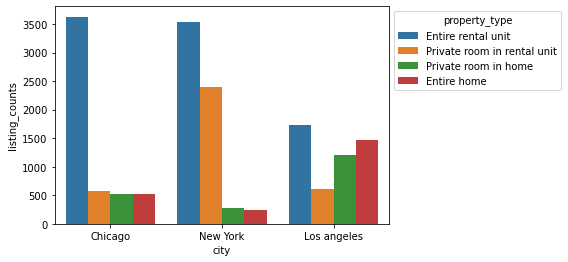

In [81]:
price_by_type = sns.barplot(data=df_avg_price_by_property,x='city', y= 'listing_counts', hue='property_type')
sns.move_legend(price_by_type, "upper left", bbox_to_anchor=(1, 1))

#### listing prices by property type in each city

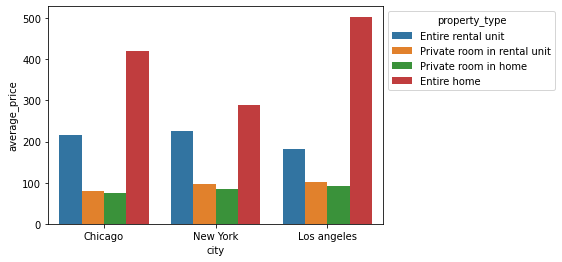

In [82]:
df_avg_price_by_property.sort_values(by=['city', 'property_type'])

import seaborn as sns
price_by_type = sns.barplot(data=df_avg_price_by_property,x='city', y= 'average_price', hue='property_type')
sns.move_legend(price_by_type, "upper left", bbox_to_anchor=(1, 1))

### Summary from correlation matrix
1. All ratings are positively correlated
2. Price is negatively correlated with number of reviews (might be 
3. Bedrooms is negatively correlated with number of reviews

In [163]:
# check more complete information by property type
spark_df_complete = spark_df.replace(float('nan'), None)
spark_df_complete.registerTempTable("spark_df_complete")

info_by_propertytype = spark.sql("select property_type, \
            count(distinct listing_id) as listing_counts, \
            avg(price) as average_price, \
            avg(bedrooms) as average_bedrooms , \
            avg(number_of_reviews) as average_number_of_reviews , \
            avg(review_scores_rating) as average_review_scores_rating ,\
            avg(review_scores_cleanliness) as average_review_scores_cleanliness, \
            avg(review_scores_checkin) as average_review_scores_checkin, \
            avg(review_scores_communication) as average_review_scores_communication, \
            avg(review_scores_location) as average_review_scores_location, \
            avg(review_scores_value) as average_review_scores_value \
          from spark_df_complete \
          group by property_type \
          order by listing_counts desc")

#info_by_propertytype.registerTempTable("info_by_propertytype")
info_by_propertytype = info_by_propertytype.toPandas()

#get only commonly poplar property type in three cities
Commom_popular_property_above = ['Entire rental unit', 'Private room in rental unit', 
                                'Private room in home', 'Entire home']
info_by_propertytype = info_by_propertytype[info_by_propertytype['property_type'].isin(Commom_popular_property_above)]

info_by_propertytype.head()

22/11/20 15:31:06 WARN TaskSetManager: Stage 237 contains a task of very large size (11748 KiB). The maximum recommended task size is 1000 KiB.


,property_type,listing_counts,average_price,average_bedrooms,average_number_of_reviews,average_review_scores_rating,average_review_scores_cleanliness,average_review_scores_checkin,average_review_scores_communication,average_review_scores_location,average_review_scores_value
0,Entire rental unit,5879,209.791661,1.541453,28.689870,4.655364,4.665666,4.818400,4.818556,4.776014,4.634829
1,Private room in rental unit,3184,97.220840,1.050070,23.198089,4.537723,4.549495,4.796295,4.790332,4.704300,4.644677
2,Entire home,2065,475.042794,2.977022,34.915994,4.758221,4.741906,4.889310,4.864561,4.818161,4.707582
3,Private room in home,1862,88.293265,1.076941,38.193435,4.703384,4.686188,4.846789,4.823810,4.742617,4.716727


#### Average rating by property type
listing of Entire home has the highest average rating of review

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Private room in rental unit'),
  Text(0, 1, 'Entire rental unit'),
  Text(0, 2, 'Private room in home'),
  Text(0, 3, 'Entire home')])

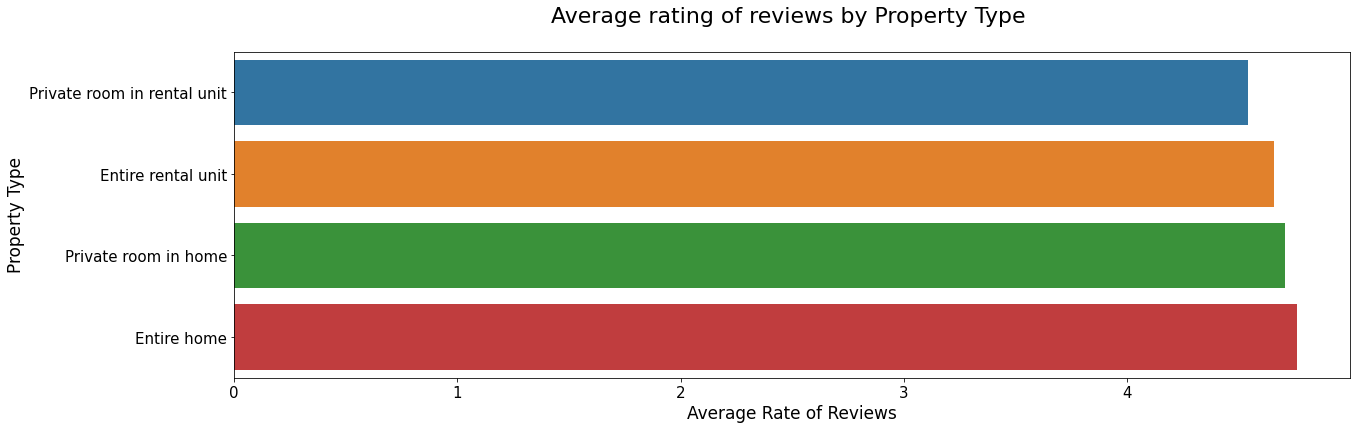

In [190]:
info = info_by_propertytype[['property_type', 'average_review_scores_rating']]
info = info.sort_values(by=['average_review_scores_rating'])

plt.figure(figsize = (20,6))
sns.barplot(x='average_review_scores_rating',y='property_type',data=info)

plt.title("Average rating of reviews by Property Type \n", fontsize = 22)
plt.xlabel('Average Rate of Reviews', fontsize = 17)
plt.ylabel('Property Type', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


In [164]:
# check more complete information by property type
spark_df_complete = spark_df.replace(float('nan'), None)
spark_df_complete.registerTempTable("spark_df_complete")

spark_df_complete = spark_df_complete.toPandas()

/Users/lianliu/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


22/11/20 15:31:08 WARN TaskSetManager: Stage 250 contains a task of very large size (11748 KiB). The maximum recommended task size is 1000 KiB.


In [165]:
info_Corr = spark_df_complete[['price', 'bedrooms', 'number_of_reviews', 
                                          'review_scores_rating', 
                                          'review_scores_checkin' ,
                                          'review_scores_cleanliness', 
                                          'review_scores_communication',
                                          'review_scores_location']]

corr = info_Corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,bedrooms,number_of_reviews,review_scores_rating,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location
price,1.000000,0.413254,-0.047416,0.032298,0.004110,0.048059,0.010353,0.067409
bedrooms,0.413254,1.000000,-0.040311,0.039849,0.032746,0.040517,0.021344,0.043633
number_of_reviews,-0.047416,-0.040311,1.000000,0.097889,0.087783,0.108517,0.086614,0.055712
review_scores_rating,0.032298,0.039849,0.097889,1.000000,0.712494,0.778663,0.778010,0.635990
review_scores_checkin,0.004110,0.032746,0.087783,0.712494,1.000000,0.599074,0.768700,0.572465
review_scores_cleanliness,0.048059,0.040517,0.108517,0.778663,0.599074,1.000000,0.624427,0.531877
review_scores_communication,0.010353,0.021344,0.086614,0.778010,0.768700,0.624427,1.000000,0.596202
review_scores_location,0.067409,0.043633,0.055712,0.635990,0.572465,0.531877,0.596202,1.000000


#### Get high rating listings of popular type and see what's the popular words used in description and name

In [176]:
df_high_rating = df[df['review_scores_rating'] >= 4.95]
df_high_rating = df_high_rating[df_high_rating['property_type'].isin(Commom_popular_property_above)]
df_high_rating_name = df_high_rating[['name']]

In [177]:
df_high_rating_name

,name
7,Andersonville - Perfect location!
11,Comfy Garden Suite in Andersonville
13,"Best in Chicago, private, amazing garden space"
16,Pullman School House Apartment - monthly rental
44,Edgebrook Lg bdr by golf course
...,...
45773,Master Suite & Private Deck in Artist's Cyn Home
45778,Disneyland Area - Great Orange County Location!
45786,"Private Room with Queen Bed, Private Bathroom"
45795,Lovely Garden House w/yard. CentralOC MONTHLY ...
